This is a working notebook to label 8 cluster kmeans result. The labeled map is sampled using the 60% subset of validation samples to identify characteristics of each class (floodwater, shadow, other)

Currently working on trying to separate flood and shadow areas based on perimeter and area characteristics.

In [1]:
# Import packages
import os, sys
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
import pandas as pd
from glob import glob
import rasterio as rio
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy as et
from skimage import measure
from skimage import morphology



%matplotlib inline

In [2]:
# Set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics','spring-2019', 'flood-detection'))
os.environ["PROJ_LIB"] = r"C:\Users\katy\Anaconda3\envs\earth-analytics-python\Library\share"

In [3]:
# Set directory to area of interest containing raster stack
aoi = "koumassi_focus_ps"

# Open existing raster stack
# band_path = os.path.join("dg-data", aoi +"\\")
# band_stack_path = os.path.join(band_path, "outputs\\indices_and_mask_files\\")
# all_bands_path = os.path.join(band_stack_path, aoi + "_all_bands.tif")
outputs_path = os.path.join("dg-data", aoi ,"outputs", "clustering","kmeans\\")
kmeans_path = outputs_path+"kmeans_koumassi_focus_ps.tif"
cluster_path = os.path.join("dg-data",aoi,"outputs","clustering","kmeans")
valid_data_path = os.path.join("validation")
valid_data = pd.read_csv(valid_data_path+"\\"+"koumassi_validation_data_60_percent.csv")
sample_pts_path = os.path.join("validation","vector-data")
sample_pts = gpd.read_file(sample_pts_path+"\\"+"validation_points_koumassi_60_percent.shp")

# Create tuples of all x coordinates and y coordinates 
x_coords = tuple(sample_pts.geometry.x)
y_coords = tuple(sample_pts.geometry.y)

In [4]:
valid_data.head()

,OBJECTID,ClassValue
0,1,2
1,2,1
2,3,1
3,4,1
4,5,1


In [5]:
with rio.open(kmeans_path) as src:
    kmeans_result = src.read()
    kmeans_meta = src.meta

kmeans_result = np.squeeze(kmeans_result)
kmeans_result.shape

(1668, 1788)

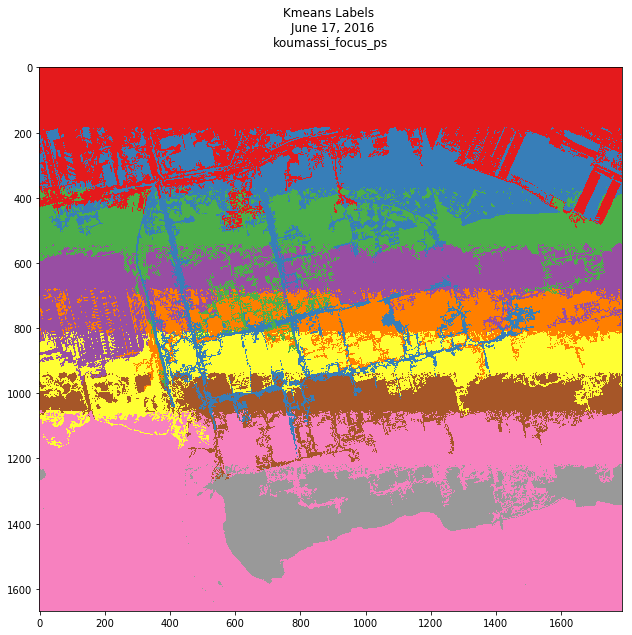

In [6]:
# Label kmeans result
kmeans_labels = measure.label(kmeans_result) 
props = measure.regionprops(kmeans_labels, intensity_image = kmeans_result) 

# # Plot flood label layer 
# fig, ax = plt.subplots(figsize=(20,10))
# labeled_plot = ax.imshow(kmeans_labels, cmap='Set1')
# ax.set(title="Kmeans Labels \n June 17, 2016\n"+aoi+"\n")
# # ax.set_axis_off()
# plt.show()

In [7]:
kmeans_labels_out = kmeans_labels[np.newaxis,:]
with rio.open(outputs_path+'kmeans_labels_'+aoi+'.tif', 'w', **kmeans_meta) as dst:
    dst.write(kmeans_labels_out.astype('float32'))

Utilize functions from regionprops_to_df

In [8]:
# Make list of all non-dunder attributes of regionprops object
def scalar_attributes_list(im_props):
    """
    Makes list of all scalar, non-dunder, non-hidden
    attributes of skimage.measure.regionprops object
    """
    
    attributes_list = []
    
    for i, test_attribute in enumerate(dir(im_props[0])):
        
        #Attribute should not start with _ and cannot return an array
        #does not yet return tuples
        if test_attribute[:1] != '_' and not\
                isinstance(getattr(im_props[0], test_attribute), np.ndarray):                
            attributes_list += [test_attribute]
            
    return attributes_list

In [9]:
def regionprops_to_df(im_props):
    """
    Read content of all attributes for every item in a list
    output by skimage.measure.regionprops
    """

    attributes_list = scalar_attributes_list(im_props)

    # Initialise list of lists for parsed data
    parsed_data = []

    # Put data from im_props into list of lists
    for i, _ in enumerate(im_props):
        parsed_data += [[]]
        
        for j in range(len(attributes_list)):
            parsed_data[i] += [getattr(im_props[i], attributes_list[j])]

    # Return as a Pandas DataFrame
    return pd.DataFrame(parsed_data, columns=attributes_list)

In [10]:
# Convert regionprops to df 
props_df = regionprops_to_df(props)

C:\Users\katy\Anaconda3\envs\earth-analytics-python\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
C:\Users\katy\Anaconda3\envs\earth-analytics-python\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


In [11]:
props_df.index.name='object_id'
props_df['labels_original']=props_df.index
props_df.head()

,area,bbox,bbox_area,centroid,convex_area,eccentricity,equivalent_diameter,euler_number,extent,filled_area,...,major_axis_length,max_intensity,mean_intensity,min_intensity,minor_axis_length,orientation,perimeter,solidity,weighted_centroid,labels_original
object_id,,,,,,,,,,,,,,,,,,,,,
0,90,"(0, 0, 28, 7)",196,"(14.88888888888889, 1.9444444444444444)",119,0.981781,10.704745,0,0.459184,91,...,28.062385,4.0,4.0,4.0,5.332297,-1.415013,59.313708,0.756303,"(14.88888888888889, 1.9444444444444444)",0
1,2,"(0, 1, 2, 2)",2,"(0.5, 1.0)",2,1.000000,1.595769,1,1.000000,2,...,2.000000,1.0,1.0,1.0,0.000000,-1.570796,0.000000,1.000000,"(0.5, 1.0)",1
2,3,"(0, 2, 3, 3)",3,"(1.0, 2.0)",3,1.000000,1.954410,1,1.000000,3,...,3.265986,7.0,7.0,7.0,0.000000,-1.570796,1.000000,1.000000,"(1.0, 2.0)",2
3,2474,"(0, 3, 37, 149)",5402,"(11.325788197251415, 65.67380759902991)",3263,0.979112,56.124813,-15,0.457979,2593,...,148.958823,4.0,4.0,4.0,30.286867,0.074776,840.635606,0.758198,"(11.325788197251415, 65.67380759902991)",3
4,1,"(0, 12, 1, 13)",1,"(0.0, 12.0)",1,0.000000,1.128379,1,1.000000,1,...,0.000000,7.0,7.0,7.0,0.000000,0.785398,0.000000,1.000000,"(0.0, 12.0)",4


In [12]:
kmeans_labels_path = outputs_path+"kmeans_labels_koumassi_focus_ps.tif"
# Sample from labeled map (kmeans_labels)
sampled_values = []

# Sample raster at each combo of x and y coordinates
with rio.open(kmeans_labels_path) as src:
#     src = np.squeeze(src)
    for val in src.sample(zip(x_coords, y_coords)):
        
        # Note that each val is an individual numpy array
        #print(val.shape)
        sampled_values.append(val)
        
# Convert list to one-dimensional array
arr = np.array([sampled_values]).squeeze()
# print(arr)

# Convert array to dataframe
kmeans_labels_df = pd.DataFrame(arr)
kmeans_labels_df.head()

,0
0,31237.0
1,24913.0
2,27334.0
3,27334.0
4,46839.0


In [ ]:
# # Sample from labeled map (kmeans_labels)
# sampled_values = []

# # Sample raster at each combo of x and y coordinates
# with rio.open(kmeans_path) as src:
# #     src = np.squeeze(src)
#     for val in src.sample(zip(x_coords, y_coords)):
        
#         # Note that each val is an individual numpy array
#         #print(val.shape)
#         sampled_values.append(val)
        
# # Convert list to one-dimensional array
# arr = np.array([sampled_values]).squeeze()
# # print(arr)

# # Convert array to dataframe

# kmeans_df = pd.DataFrame(arr)
# kmeans_df.head()

In [16]:
# labels_valid_data = [kmeans_labels_df,valid_data]
labels_valid_data_df = pd.concat([kmeans_labels_df,valid_data], axis=1, sort=False)
labels_valid_data_df.columns = ["labels","object_id","validation_data"]
labels_valid_data_df = labels_valid_data_df.drop_duplicates(subset="labels")
labels_valid_data_df=labels_valid_data_df.sort_values(by="labels")
# labels_clusters_df_nodups
labels_valid_data_df.head()

,labels,object_id,validation_data
523,25.0,524,3
536,36.0,537,3
535,50.0,536,3
531,171.0,532,3
52,294.0,53,1


In [19]:
subset_props_labels = props_df[props_df.index.isin(labels_valid_data_df['labels'])]
# subset_props_labels = subset_props_labels.join(labels_clusters_df_nodups)     
subset_props_labels['labels']=subset_props_labels.index
# rst = rpt[rpt['STK_ID'].isin(stk_list)].
subset_props_labels.head()

C:\Users\katy\Anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,area,bbox,bbox_area,centroid,convex_area,eccentricity,equivalent_diameter,euler_number,extent,filled_area,...,max_intensity,mean_intensity,min_intensity,minor_axis_length,orientation,perimeter,solidity,weighted_centroid,labels_original,labels
object_id,,,,,,,,,,,,,,,,,,,,,
25,500,"(0, 249, 149, 293)",6556,"(95.62, 271.934)",1976,0.996553,25.231325,0,0.076266,502,...,7.0,7.0,7.0,14.802166,-1.336416,342.539105,0.253036,"(95.62, 271.934)",25,25
36,6,"(0, 296, 6, 298)",12,"(2.5, 296.5)",8,0.991364,2.763953,1,0.500000,6,...,7.0,7.0,7.0,0.925520,-1.314602,4.414214,0.750000,"(2.5, 296.5)",36,36
50,4,"(0, 439, 3, 441)",6,"(0.75, 439.5)",5,0.836166,2.256758,1,0.666667,4,...,8.0,8.0,8.0,1.862491,-1.311223,3.414214,0.800000,"(0.75, 439.5)",50,50
171,5,"(0, 1537, 1, 1542)",5,"(0.0, 1539.0)",5,1.000000,2.523133,1,1.000000,5,...,1.0,1.0,1.0,0.000000,-0.000000,3.000000,1.000000,"(0.0, 1539.0)",171,171
294,229,"(4, 1073, 31, 1094)",567,"(18.24454148471616, 1083.4541484716158)",413,0.794877,17.075475,-3,0.403880,237,...,6.0,6.0,6.0,17.717034,1.276156,147.189863,0.554479,"(18.24454148471616, 1083.4541484716158)",294,294


In [20]:
subset_props = pd.merge(subset_props_labels,labels_valid_data_df, on='labels')
subset_props.head()

# props_labels_clusters = subset_props_labels[subset_props_labels.index.isin(labels_clusters_df('labels'))].add(labels_clusters_df('clusters'))

# props_labels_clusters = subset_props_labels.merge(labels_clusters_df, on='labels')
# props_labels_clusters = labels_clusters_df.join(subset_props_labels.set_index('object_id').bar.rename('new'))

,area,bbox,bbox_area,centroid,convex_area,eccentricity,equivalent_diameter,euler_number,extent,filled_area,...,min_intensity,minor_axis_length,orientation,perimeter,solidity,weighted_centroid,labels_original,labels,object_id,validation_data
0,500,"(0, 249, 149, 293)",6556,"(95.62, 271.934)",1976,0.996553,25.231325,0,0.076266,502,...,7.0,14.802166,-1.336416,342.539105,0.253036,"(95.62, 271.934)",25,25,524,3
1,6,"(0, 296, 6, 298)",12,"(2.5, 296.5)",8,0.991364,2.763953,1,0.500000,6,...,7.0,0.925520,-1.314602,4.414214,0.750000,"(2.5, 296.5)",36,36,537,3
2,4,"(0, 439, 3, 441)",6,"(0.75, 439.5)",5,0.836166,2.256758,1,0.666667,4,...,8.0,1.862491,-1.311223,3.414214,0.800000,"(0.75, 439.5)",50,50,536,3
3,5,"(0, 1537, 1, 1542)",5,"(0.0, 1539.0)",5,1.000000,2.523133,1,1.000000,5,...,1.0,0.000000,-0.000000,3.000000,1.000000,"(0.0, 1539.0)",171,171,532,3
4,229,"(4, 1073, 31, 1094)",567,"(18.24454148471616, 1083.4541484716158)",413,0.794877,17.075475,-3,0.403880,237,...,6.0,17.717034,1.276156,147.189863,0.554479,"(18.24454148471616, 1083.4541484716158)",294,294,53,1


In [21]:
# Subset based on shadow, water, other
shadow = subset_props.loc[subset_props['validation_data']==1]
flood = subset_props.loc[subset_props['validation_data']==2]
other = subset_props.loc[subset_props['validation_data']==3]

In [22]:
shadow.head()

,area,bbox,bbox_area,centroid,convex_area,eccentricity,equivalent_diameter,euler_number,extent,filled_area,...,min_intensity,minor_axis_length,orientation,perimeter,solidity,weighted_centroid,labels_original,labels,object_id,validation_data
4,229,"(4, 1073, 31, 1094)",567,"(18.24454148471616, 1083.4541484716158)",413,0.794877,17.075475,-3,0.403880,237,...,6.0,17.717034,1.276156,147.189863,0.554479,"(18.24454148471616, 1083.4541484716158)",294,294,53,1
5,1,"(4, 1697, 5, 1698)",1,"(4.0, 1697.0)",1,0.000000,1.128379,1,1.000000,1,...,4.0,0.000000,0.785398,0.000000,1.000000,"(4.0, 1697.0)",310,310,434,1
6,1,"(15, 1251, 16, 1252)",1,"(15.0, 1251.0)",1,0.000000,1.128379,1,1.000000,1,...,6.0,0.000000,0.785398,0.000000,1.000000,"(15.0, 1251.0)",624,624,54,1
17,11,"(133, 1307, 139, 1313)",36,"(135.1818181818182, 1308.7272727272727)",21,0.670350,3.742410,1,0.305556,11,...,4.0,4.969769,0.453150,8.414214,0.523810,"(135.1818181818182, 1308.7272727272727)",4554,4554,202,1
19,524,"(153, 1762, 185, 1788)",832,"(168.32442748091603, 1775.9790076335878)",575,0.585065,25.829780,-1,0.629808,526,...,3.0,24.130339,-0.973707,103.426407,0.911304,"(168.32442748091603, 1775.9790076335878)",5296,5296,173,1


In [23]:
print('Shadow Perimeter min,max,mean:',shadow['perimeter'].min(), shadow['perimeter'].max(), shadow['perimeter'].mean())
print('Flood Perimeter min,max,mean:',flood['perimeter'].min(), flood['perimeter'].max(), flood['perimeter'].mean())

Shadow Perimeter min,max,mean: 0.0 257.68733752154174 14.445812754460656
Flood Perimeter min,max,mean: 0.0 909.7249634685276 22.862692389916447


In [24]:
print('Shadow Area min,max,mean:',shadow['area'].min(), shadow['area'].max(), shadow['area'].mean())
print('Flood Area min,max,mean:',flood['area'].min(), flood['area'].max(), flood['area'].mean())

Shadow Area min,max,mean: 1 524 24.005405405405405
Flood Area min,max,mean: 1 1951 42.61666666666667


In [48]:
shadow['new']=(shadow.perimeter*shadow.perimeter/shadow.area)
flood['new']=(flood.perimeter*flood.perimeter/flood.area)
# print('Flood Perimeter/Area min,max,mean:',(flood.perimeter*flood.perimeter/flood.area).min(), (flood.perimeter*flood.perimeter/flood.area).max(), (flood.perimeter*flood.perimeter/flood.area).mean())


print('Shadow Perimeter/Area min,max,mean:',(shadow['perimeter']*shadow['perimeter']/shadow['area']).min(), (shadow['perimeter']*shadow['perimeter']/shadow['area']).max(), (shadow['perimeter']*shadow['perimeter']/shadow['area']).mean())
print('Flood Perimeter/Area min,max,mean:',(flood['perimeter']*flood['perimeter']/flood['area']).min(), (flood['perimeter']*flood['perimeter']/flood['area']).max(), (flood['perimeter']*flood['perimeter']/flood['area']).mean())

C:\Users\katy\Anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\katy\Anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Shadow Perimeter/Area min,max,mean: 0.0 162.3539460120806 9.899215917811503
Flood Perimeter/Area min,max,mean: 0.0 424.1924700962654 13.494535872597892


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002393BD55240>]],
      dtype=object)

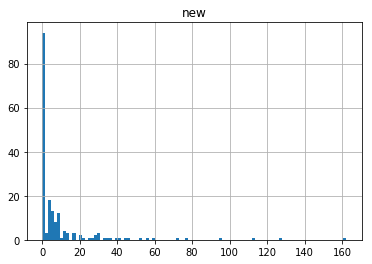

In [47]:
shadow.hist(column='new', bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002393F92CE80>]],
      dtype=object)

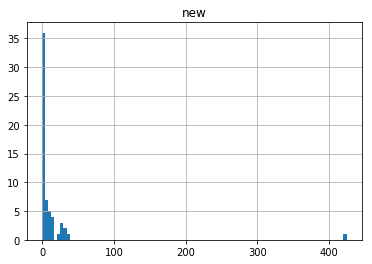

In [49]:
flood.hist(column='new', bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023939EDFF98>]],
      dtype=object)

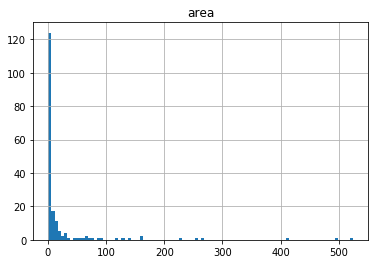

In [36]:
shadow.hist(column='area', bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002393D04C390>]],
      dtype=object)

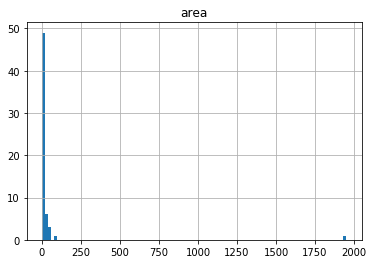

In [37]:
flood.hist(column='area', bins=100)